# High Value Customers Identification

## 0. Importação de Bibliotecas e *Helper Functions*

In [118]:
import re
import math
import warnings
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap
from plotly              import express as px
from matplotlib          import pyplot as plt
from sklearn.cluster     import KMeans
from sklearn.metrics     import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler

In [4]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

## 1. Carregando os Dados

In [5]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN


In [6]:
df_raw = df_raw.drop(columns='Unnamed: 8')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 2. Descrição dos Dados

In [39]:
df1 = df_raw.copy()

### 2.1 Renomeando Colunas

In [40]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [41]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = new_cols
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 2.2 Dicionário de Colunas

|     Coluna    |              Significado              |
| ------------- | ------------------------------------- |
|   invoice_no   | identificador único de cada transação   |
|   stock_code   | código do item                        |
|   description | nome do item                          |
|   quantity    | quantidade de cada item por transação |
|   invoice_date | data da transação                     |
|   unit_price   | preço do item por unidade             |
|   customer_id  | identificador único do cliente        |
|   country     | país em que o cliente reside          |

### 2.3 Dimensões

In [42]:
print(f'Número de linhas/registros: {df1.shape[0]}')
print(f'Número de colunas/atributos: {df1.shape[1]}')

Número de linhas/registros: 541909
Número de colunas/atributos: 8


### 2.4 Tipos de Dados

In [43]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 2.5 Registros Duplicados

In [44]:
df1.duplicated().sum()

5269

### 2.6 Valores Nulos

In [45]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.7 Substituindo Valores Nulos

Vou adotar uma estratégia de atribuição de *customer_id* para as transações que não contém essa informação, para não ter que excluir esses registros e perder o comportamento de compra desses clientes - o que vai influenciar na clusterização posteriormente.

Primeiro, vou dividir o conjunto de dados em dois dataframes, um contendo somente os registros sem valores para o atributo *customer_id* e outro contendo somente o registro com valores.

In [46]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

print(f'Quantidade de registros do dataframe com valores nulos: {df_missing.shape[0]}')
print(f'Quantidade de registros do dataframe sem valores nulos: {df_not_missing.shape[0]}')

Quantidade de registros do dataframe com valores nulos: 135080
Quantidade de registros do dataframe sem valores nulos: 406829


Feito isso, primeiro vou verificar se existem transações em comum nesses dois sub-conjunto de dados - se existem, posso atribuir o *customer_id* já existente.

In [47]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


Infelizmente não existe nenhuma transação em comum, então vou partir para a estratégia de atribuir um valor para o *customer_id* para cada transação diferente (baseado no atributo *invoice_no*). Como ponto de partida, vou usar do maior número de *customer_id* que temos.

In [48]:
print(f'Maior valor para customer_id: {df_not_missing["customer_id"].max()}')

Maior valor para customer_id: 18287.0


In [49]:
df_aux = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_aux['customer_id'] = np.arange(19000, 19000 + len(df_aux), 1)
df_aux.head()

,invoice_no,customer_id
622,536414,19000
1443,536544,19001
1970,536545,19002
1971,536546,19003
1972,536547,19004


Agora vou juntar esse *dataframe* com o conjunto de dados original e fazer as devidas alterações, mantendo os valores já existentes para *customer_id* e atribuindo os novos valores aos registros faltantes.

In [50]:
df1 = pd.merge(df1, df_aux, on='invoice_no', how='left')

df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.00
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.00


In [51]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

Ainda temos alguns valores nulos para o atributo *description*, mas irei remover esse atributo do conjunto de dados em etapa posterior, já que é não muito informativa para o problema de negócio que estou resolvendo.

### 2.8 Alterando Tipos de Dados

#### 2.8.1 *InvoiceDate*

In [52]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1['invoice_date'].head()

0   2016-11-29
1   2016-11-29
2   2016-11-29
3   2016-11-29
4   2016-11-29
Name: invoice_date, dtype: datetime64[ns]

#### 2.8.2 *CustomerID*

In [53]:
df1['customer_id'] = df1['customer_id'].astype('int64')
df1['customer_id'].head()

0    17850
1    17850
2    17850
3    17850
4    17850
Name: customer_id, dtype: int64

### 2.9 Análise Estatística Descritiva

#### 2.9.1 Atributos Numéricos

In [54]:
df1_numerical = df1.select_dtypes(include=['int64', 'float64'])
df1_numerical = df1_numerical.drop(columns='customer_id')
df1_numerical.head()

,quantity,unit_price
0,6,2.55
1,6,3.39
2,8,2.75
3,6,3.39
4,6,3.39


In [55]:
df_mean     = pd.DataFrame(df1_numerical.apply(np.mean)).T
df_median   = pd.DataFrame(df1_numerical.apply(np.median)).T
df_std      = pd.DataFrame(df1_numerical.apply(np.std)).T
df_min      = pd.DataFrame(df1_numerical.apply(min)).T
df_max      = pd.DataFrame(df1_numerical.apply(max)).T
df_range    = pd.DataFrame(df1_numerical.apply(lambda x: x.max() - x.min())).T
df_skew     = pd.DataFrame(df1_numerical.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df1_numerical.apply(lambda x: x.kurtosis())).T

In [56]:
df_desc = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
df_desc.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72


Nessa pequena tabela já podemos verificar que: 
- Aparentemente temos quantidade de produtos negativa (o que pode representar um cancelamento de venda ou troca/devolução de um produto comprado); 
- Além disso, temos um número grande (80995) como quantidade máxima de produtos vendidos, o que pode representar um erro de digitação ou um *outlier*; 
- Falando de preço, temos um produto com preço negativo, o que pode representar um erro de digitação ou cancelamento/troca/devolução de produto.

#### 2.9.2 Atributos Categóricos

In [57]:
df1_cat = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
df1_cat.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### *invoice_no*

Aparentemente, a variável *invoice_no* apresenta somente números, mas se tentamos converter o tipo de dado de *object* para *int*, não é possível, indicando que existe algum registro que contem um *char* além de número inteiros. Exemplo:

In [58]:
df_invoice_letter = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_invoice_letter.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


Dessa análise de 05 registros com letras no *invoice_no* podemos ver que a quantidade do produto é negativa. Assim, vou verificar se isso acontece com todos os registros que contém letras.

In [59]:
print('Quantidade de registros com letras: {}'.format(len(df_invoice_letter)))
print('Quantidade de registros com quantidade negativa: {}'.format(len(df_invoice_letter[df_invoice_letter['quantity'] < 0])))

Quantidade de registros com letras: 9291
Quantidade de registros com quantidade negativa: 9288


Diante disso, podemos concluir que praticamente todos os códigos de *invoice_no* que contém letras representam uma devolução, estorno ou algo do gênero.

##### *stock_code*

Aqui temos a mesma situação da variável anterior, não é possível converter de *object* para *int* por causa da presença de letras junto com números, bem como de registros compostos puramente por letras. 

Assim, vou utilizar novamente de REGEX para verificar quais são os códigos compostos puramente por letras, para depois avaliar se vou retirar esses registros na etapa de Filtragem de Variáveis.

In [60]:
df1_cat.loc[df1_cat['stock_code'].apply(lambda x: bool(re.search('^[a-zA-z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

##### *description*

Aqui só vou verificar quantas descrições diferentes temos de produtos. 

In [61]:
len(df1_cat['description'].unique())

4224

##### *country*

Aqui vou verificar de quais países diferentes os clientes compraram os produtos, e o número de clientes por país.

In [62]:
df1_cat['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [63]:
df_customer_country = df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)
df_customer_country.head(10)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


A maior parte dos clientes se encontram no Reino Unido, sendo o restante dos clientes concentrados em outros países da Europa.

## 3. Filtragem de Variáveis

Como temos algumas variáveis com 'sujeira', vou filtrar os dados primeiro para depois criar novas variáveis para auxiliar na clusterização dos clientes.

In [64]:
df2 = df1.copy()

### 3.1 *quantity*

Para essa variável, já vimos que existem valores negativos, então vou assumir que esses valores representam uma devolução de produto por parte do cliente. 

O número de devoluções deve ser levado em conta no momento da clusterização e da possível participação do cliente no novo programa de fidelização da empresa.

Assim, vou criar dois conjunto de dados separados - um com quantidade de produtos acima de 0 (representando as compras) e outro abaixo de 0 (representando as devoluções).

In [65]:
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchases = df2.loc[df2['quantity'] > 0, :]

### 3.2 *unit_price*

Como também já visto acima, existem transações com preços por unidade negativos, assim vou filtrar o conjunto de dados original para que contenha apenas transações com preços por unidade positivos, para não afetar o cálculo do faturamento bruto por cliente na etapa posterior.

In [66]:
df2 = df2.loc[df2['unit_price'] > 0.010, :]

### 3.3 *stock_code*

Aqui também já vimos que existem código de produtos composto exclusivamente por letras, de forma que vou retirar esses registros do conjunto de dados.

In [67]:
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

### 3.4 *description*

Vou optar por remover essa variável do conjunto de dados, vez que ela não me parece ter muita relevância para a clusterização dos clientes.

In [68]:
df2 = df2.drop(columns='description', axis=1)

### 3.5 *country*

Vou remover alguns registros de países que não fazem muito sentido para o projeto.

In [69]:
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

## 4. *Feature Engineering* - Criação de Variáveis

In [89]:
df3 = df2.copy()

Nessa etapa vou criar novos atributos/variáveis para ser possível a clusterização dos clientes.

In [90]:
df3.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'customer_id'],
      dtype='object')

In [91]:
df_ref = df3.drop(columns=['invoice_no', 'stock_code', 'quantity', 
                           'invoice_date', 'unit_price', 'country']).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 4.1 Receita Bruta

Para a métrica monetária, vou adotar o faturamento bruto por cliente, calculado com base somente nas compras feitas.

In [92]:
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

In [93]:
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,gross_revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [94]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3237.54
2,12583,7281.38
3,13748,948.25
4,15100,876.00


In [95]:
df_ref.isna().sum()

customer_id       0
gross_revenue    90
dtype: int64

### 4.2 Recência

Número de dias desde a última compra feita pelo cliente.

Como último dia para comparação, vou pegar a data da última transação no conjunto de dados que contém somente compras, vez que não me interessa quando o cliente devolveu um produto pela última vez.

In [96]:
# Obtendo a data de transação mais recente por cliente
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency.head()

,customer_id,invoice_date
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [97]:
# Calculando o número de dias desde a última transação
df_recency['recency'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns=['invoice_date'])
df_recency.head()

,customer_id,recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [98]:
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency
0,17850,5391.21,372.00
1,13047,3237.54,31.00
2,12583,7281.38,2.00
3,13748,948.25,95.00
4,15100,876.00,333.00


In [99]:
df_ref.isna().sum()

customer_id       0
gross_revenue    90
recency          90
dtype: int64

### 4.3 Quantidade de Compras

Aqui estou verificando quantas transações diferentes cada cliente vez.

Da mesma forma que na recência, o que me interessa aqui é quantas vezes o cliente comprou um produto, e não devolveu.

In [100]:
df_qty_purchases = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns= {'invoice_no': 'qty_purchases'})
df_qty_purchases.head()

,customer_id,qty_purchases
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [101]:
df_ref = pd.merge(df_ref, df_qty_purchases, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,qty_purchases
0,17850,5391.21,372.00,34.00
1,13047,3237.54,31.00,10.00
2,12583,7281.38,2.00,15.00
3,13748,948.25,95.00,5.00
4,15100,876.00,333.00,3.00


In [105]:
df_ref.isna().sum()

customer_id       0
gross_revenue    90
recency          90
qty_purchases    90
qty_products     90
dtype: int64

### 4.4 Quantidade de Produtos Comprados

Aqui estou verificando a quantidade total de produtos que cada cliente comprou.

In [103]:
df_qty_products = df_purchases[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns= {'quantity': 'qty_products'})
df_qty_products.head()

,customer_id,qty_products
0,12346,1
1,12347,15
2,12348,10
3,12349,12
4,12350,5


In [104]:
df_ref = pd.merge(df_ref, df_qty_products, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,qty_purchases,qty_products
0,17850,5391.21,372.00,34.00,6.00
1,13047,3237.54,31.00,10.00,12.00
2,12583,7281.38,2.00,15.00,25.00
3,13748,948.25,95.00,5.00,8.00
4,15100,876.00,333.00,3.00,2.00


In [106]:
df_ref.isna().sum()

customer_id       0
gross_revenue    90
recency          90
qty_purchases    90
qty_products     90
dtype: int64

### 4.5 Ticket Médio

O ticket médio corresponde quanto, na média, cada cliente gasta por compra. 

Aqui também o que me interessa são as compras feitas por cada cliente, e não as devoluções.

In [108]:
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket.head()

,customer_id,avg_ticket
0,12346,77183.60
1,12347,23.68
2,12348,57.98
3,12349,24.08
4,12350,19.67


In [109]:
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,qty_purchases,qty_products,avg_ticket
0,17850,5391.21,372.00,34.00,6.00,18.15
1,13047,3237.54,31.00,10.00,12.00,18.82
2,12583,7281.38,2.00,15.00,25.00,29.48
3,13748,948.25,95.00,5.00,8.00,33.87
4,15100,876.00,333.00,3.00,2.00,292.00


In [110]:
df_ref.isna().sum()

customer_id       0
gross_revenue    90
recency          90
qty_purchases    90
qty_products     90
avg_ticket       90
dtype: int64

Como a maioria das métricas até agora foi calculada sobre o conjunto de dados contendo somente compras dos clientes, esses valores nulos que aparecem no conjunto de dados de referência representam clientes que nunca fizeram efetivamente uma compra ou o registro da compra não consta nos dados que temos acesso (recorte temporal ou erro de sistema). 

### 4.6 Retornos/Devoluções

In [111]:
df_n_returns = df_returns[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().drop_duplicates().rename(columns={'invoice_no': 'returns'})
df_n_returns.head()

,customer_id,returns
0,12346,1
1,12352,10
2,12359,6
3,12362,8
4,12365,1


In [112]:
df_ref = pd.merge(df_ref, df_n_returns, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,qty_purchases,qty_products,avg_ticket,returns
0,17850,5391.21,372.00,34.00,6.00,18.15,15.00
1,13047,3237.54,31.00,10.00,12.00,18.82,24.00
2,12583,7281.38,2.00,15.00,25.00,29.48,4.00
3,13748,948.25,95.00,5.00,8.00,33.87,NaN
4,15100,876.00,333.00,3.00,2.00,292.00,3.00


In [113]:
df_ref.isna().sum()

customer_id         0
gross_revenue      90
recency            90
qty_purchases      90
qty_products       90
avg_ticket         90
returns          4143
dtype: int64

Quanto às devoluções, temos mais valores nulos representando clientes que nunca devolveram produtos ou que o registro da devolução não consta nos dados que temos acesso (recorte temporal ou erro de sistema). Por isso, vou substituir esses valores nulos com 0, representando que o cliente não fez nenhuma devolução.

In [119]:
df_ref['returns'] = df_ref['returns'].apply(lambda x: 0 if math.isnan(x) else x)
df_ref.head()

,customer_id,gross_revenue,recency,qty_purchases,qty_products,avg_ticket,returns
0,17850,5391.21,372.00,34.00,6.00,18.15,15.00
1,13047,3237.54,31.00,10.00,12.00,18.82,24.00
2,12583,7281.38,2.00,15.00,25.00,29.48,4.00
3,13748,948.25,95.00,5.00,8.00,33.87,0.00
4,15100,876.00,333.00,3.00,2.00,292.00,3.00


## 5. Análise Exploratória de Dados

In [86]:
df4 = df_ref.dropna()

## 6. Preparação dos Dados

In [87]:
df5 = df4.copy()

In [88]:
ss = StandardScaler()

In [89]:
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency'] = ss.fit_transform(df5[['recency']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])

In [90]:
df5.sample()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns
2342,17746,-0.28,2.06,-0.55,-0.05,-0.32


## 7. *Feature Selection* - Seleção de Variáveis

In [91]:
df6 = df5.copy()

## 8. *Hyperparemeter Fine Tunning* - Encontrando o Melhor Número de Clusters

Para encontrar o melhor valor de clusters, vou usar do algoritmo *KMeans*, e comparar a performance de acordo com métricas de *Compactness* e *Separation*.

In [92]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency,frequency,avg_ticket,returns
0,0.08,3.61,2.26,-0.05,0.82
1,-0.07,-0.40,0.22,-0.05,1.60
2,0.21,-0.74,0.64,-0.04,-0.15
4,-0.23,3.15,-0.38,0.07,-0.23
5,0.03,-0.47,0.64,-0.03,0.03


In [93]:
n_clusters = [2, 3, 4, 5, 6, 7]

### 8.1 WCSS (*Within-Cluster Sum of Square*)

A métrica usada para verificar a *Compactness* dos clusters vai ser o WCSS (*Within-Cluster Sum of Square*) 

Para verificar essa métrica para diferentes números de clusters, vou usar do método do Cotovelo (*Elbow Method*).

De acordo com esse método, o melhor valor de clusters vai ser aquele que apresenta a maior diferença/variação em comparação com o próximo valor (o cotovelo no gráfico).

Para facilitar, a função *KElbowVisualizer* já indica qual o melhor valor para o número de clusters no gráfico.

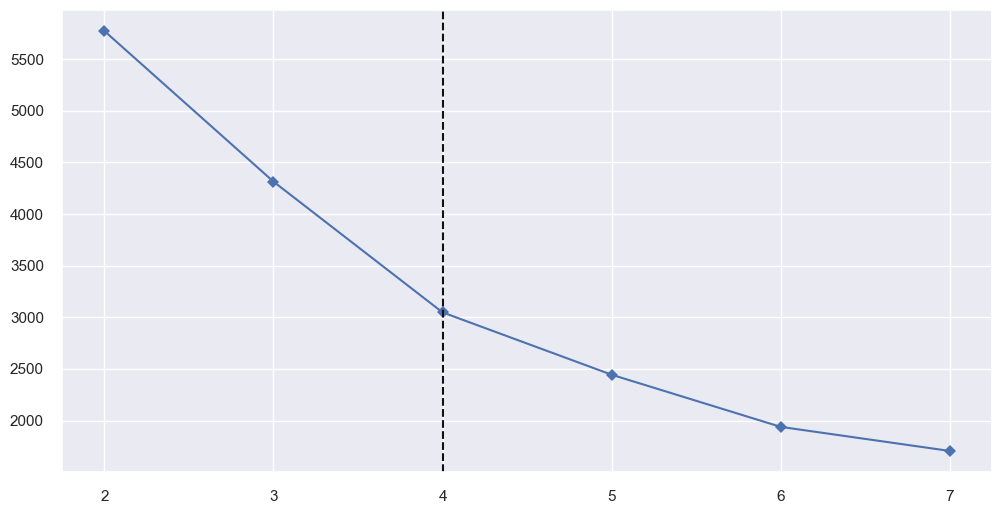

In [94]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a WCSS, o melhor número de clusters é 4. 

### 8.2 SS (*Silhouette Score*)

A métrica usada para verificar a *Separation* dos clusters vai ser a *Silhouette Score*

Para verificar essa métrica para diferentes números de clusters, também vou usar da função *KElbowVisualizer*, mas passando como parâmetro a métrica *silhouette*.

De acordo com essa métrica, o melhor valor para o número de clusters vai ser aquele que apresentar uma *Silhouette Score* mais próxima de 1. 

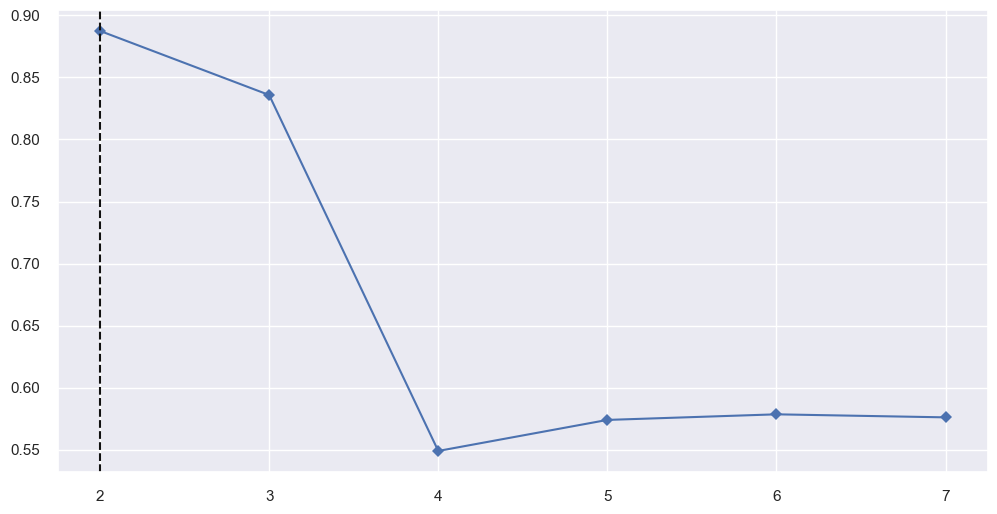

In [95]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a SS, o melhor número de clusters é 2, mas podemos ver que 3 clusters não apresentam uma performance muito pior. 

Assim, vou seguir com 3 clusters para o conjunto de dados.

### 8.3 *Silhouette Analysis*

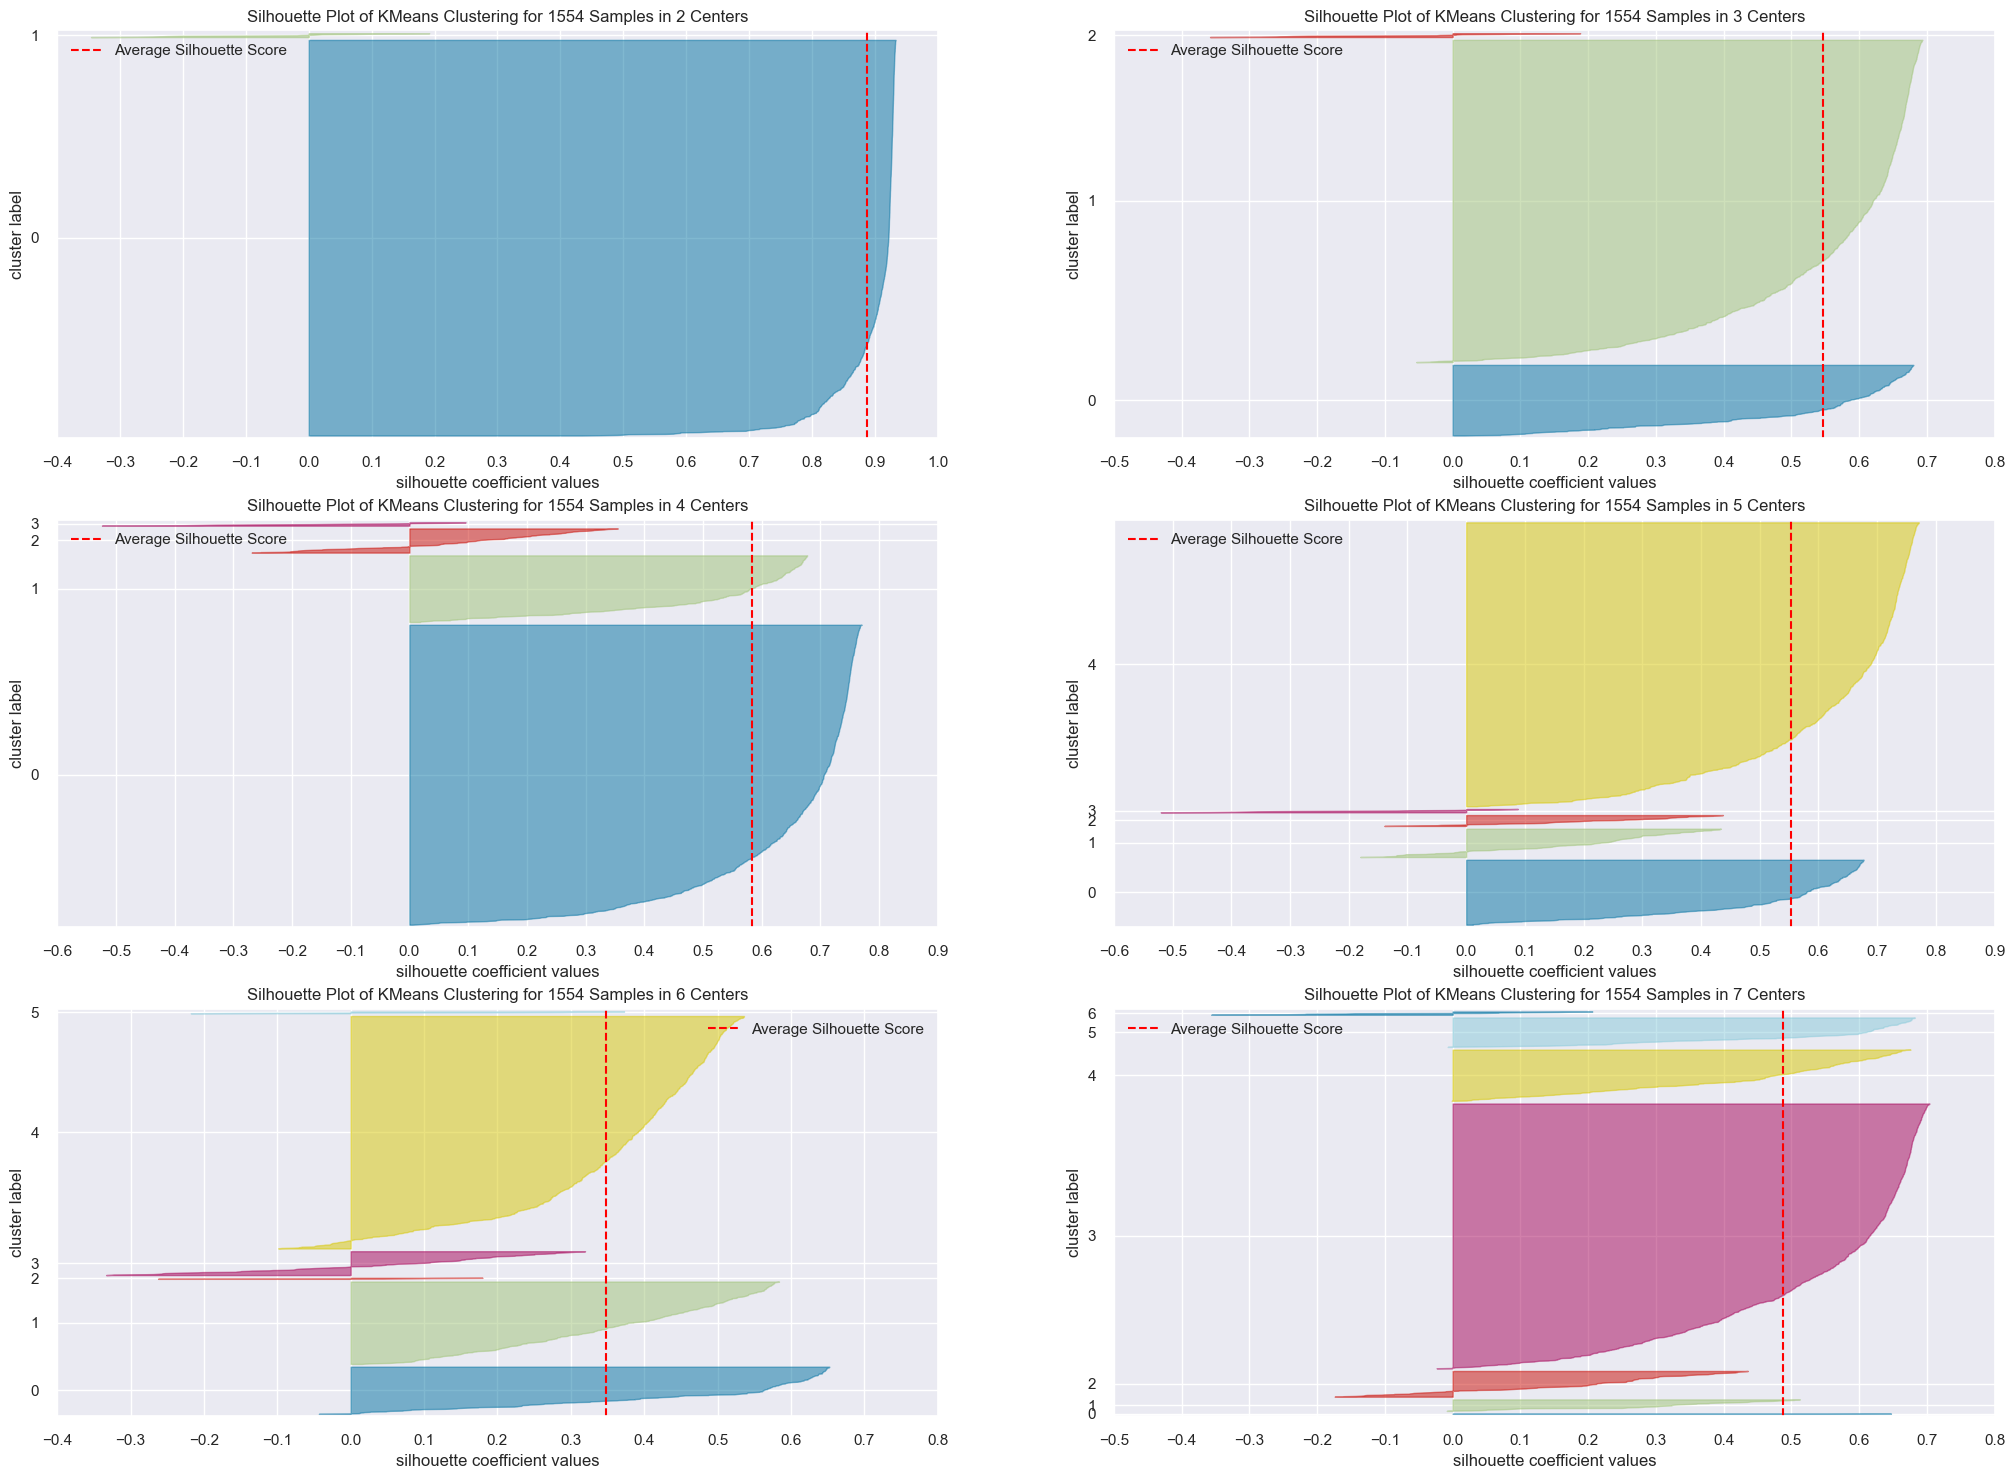

In [96]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in n_clusters:
  km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
  q, mod = divmod(k, 2)
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 9. *Machine Learning*

### 9.1 *KMeans*

In [97]:
# Modelo
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treinamento
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

#### 9.1.2 *Cluster Validation*

In [98]:
# WSS
print('WSS: {:.2f}'.format(kmeans.inertia_))
# SS
print('SS: {:.2f}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 4506.56
SS: 0.55


## 10. *Cluster Analysis*

In [99]:
df4.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns
0,17850,5391.21,372.00,34.00,18.15,15.00
1,13047,3237.54,31.00,10.00,18.82,24.00
2,12583,7281.38,2.00,15.00,29.48,4.00
4,15100,876.00,333.00,3.00,292.00,3.00
5,15291,4668.30,25.00,15.00,45.32,6.00


In [100]:
#df7 = df6.copy()
df7 = df4.copy()
df7['cluster'] = labels
df7.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,returns,cluster
0,17850,5391.21,372.00,34.00,18.15,15.00,0
1,13047,3237.54,31.00,10.00,18.82,24.00,1
2,12583,7281.38,2.00,15.00,29.48,4.00,1
4,15100,876.00,333.00,3.00,292.00,3.00,0
5,15291,4668.30,25.00,15.00,45.32,6.00,1


### 10.1 *Visual Inspection*

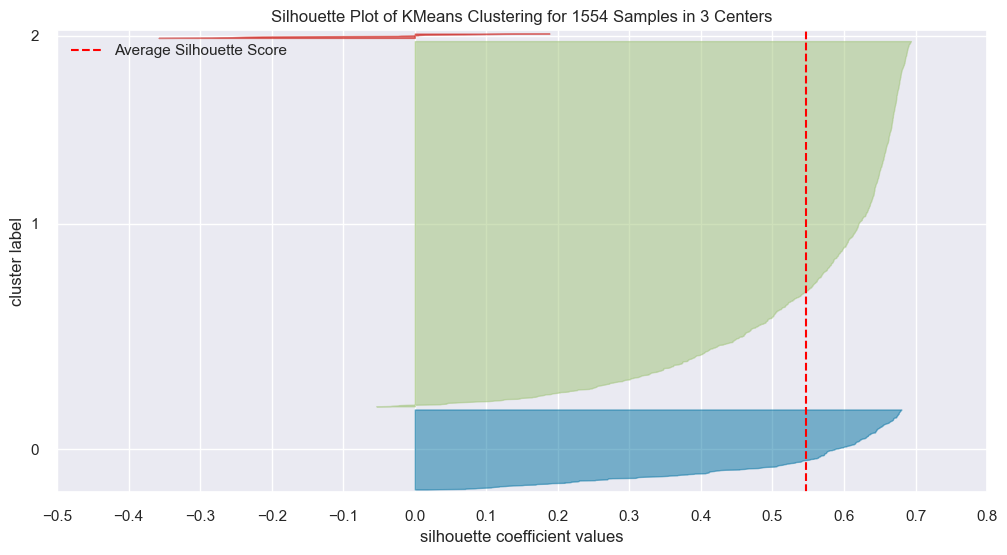

In [101]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 10.2 *2D Plot*

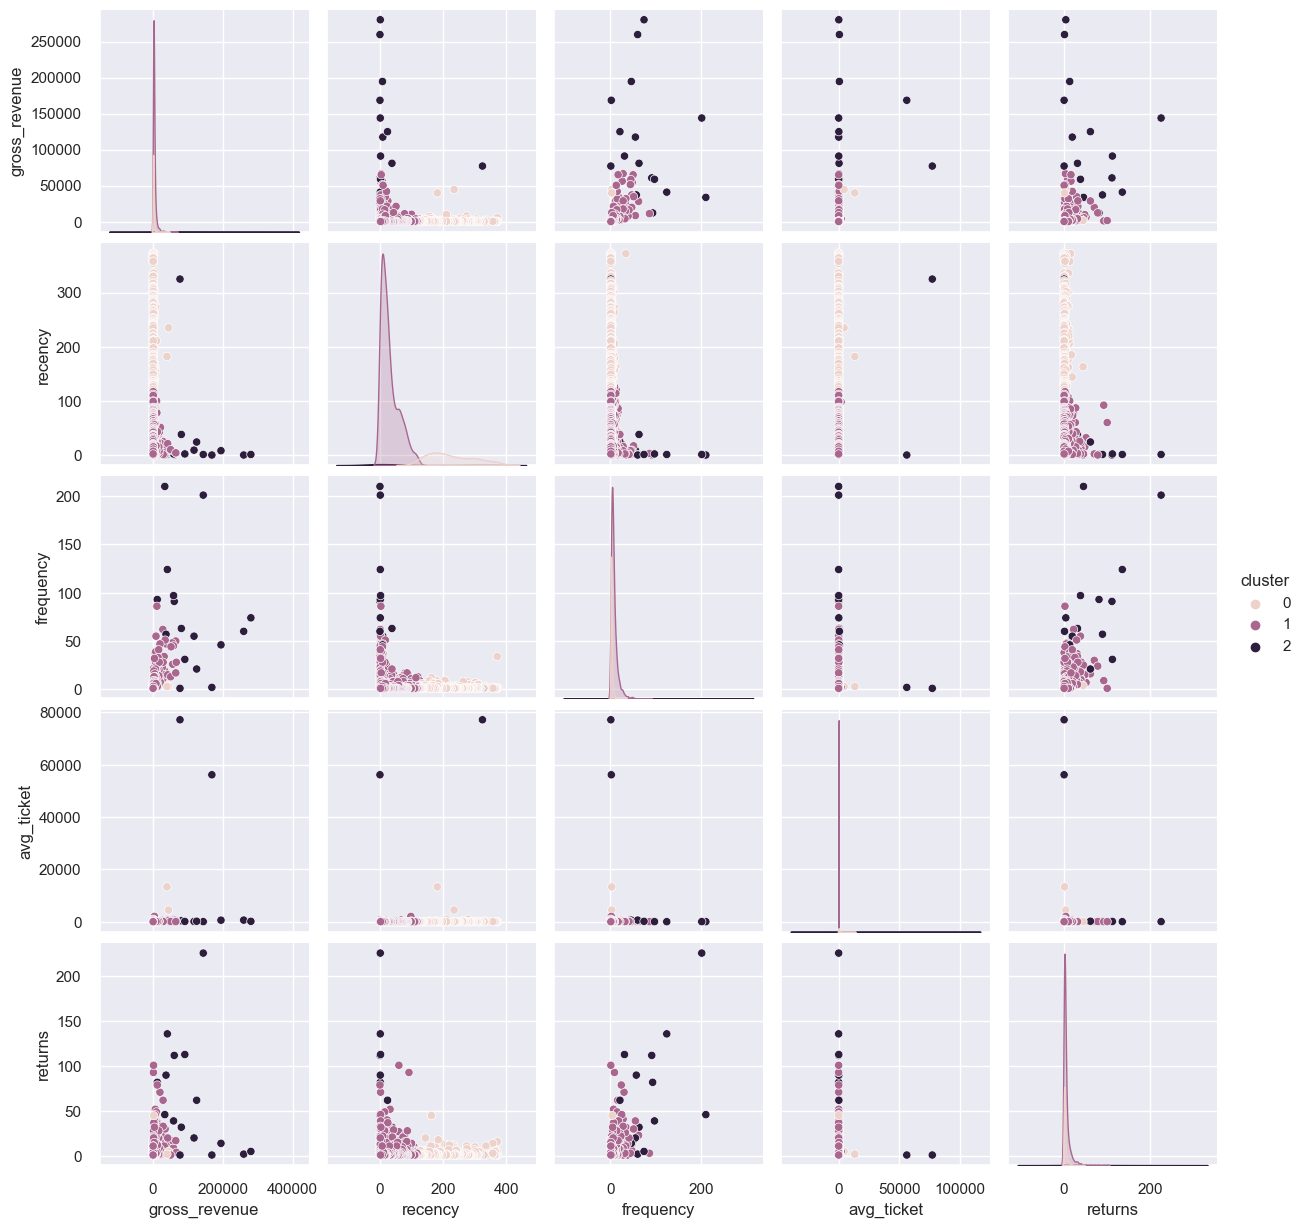

In [109]:
df_viz = df7.drop(columns='customer_id')
sns.pairplot(df_viz, hue='cluster');

### 10.3 *UMAP*

Ferramenta para nos dar ideia de como está organizado o cluster em alta dimensionalidade.

In [110]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform (X)

In [111]:
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

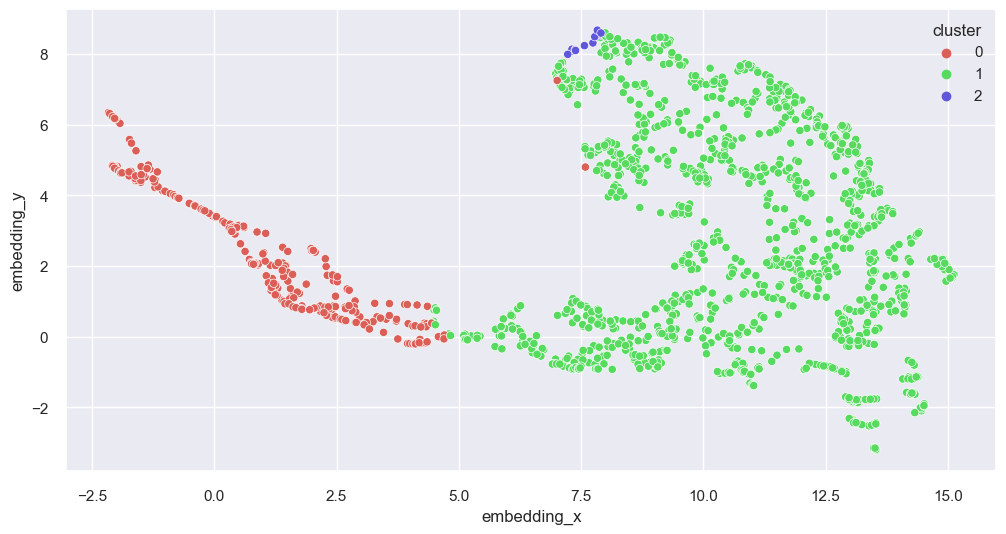

In [112]:
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

Se os pontos de mesmas cores estão próximos uns dos outros, isso significa que em alta dimensionalidade, os pontos estão dentro do mesmo cluster.

### 10.4 *Cluster Profile*

In [102]:
# Número de clientes por cluster
df_cluster = df7[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Porcentagem em relação ao total de clientes
df_cluster['percentage'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

In [103]:
# Média de GrossRevenue por cluster
df_avg_revenue = df7[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, how='inner', on='cluster')

In [104]:
# Média de RecencyDays por cluster
df_avg_recency = df7[['recency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

In [105]:
# Média de Frequency por cluster
df_avg_frequency = df7[['frequency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

In [106]:
# Ticket médio por cluster
df_ticket = df7[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

In [107]:
# Média de retornos por cluster
df_return = df7[['returns', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_return, how='inner', on='cluster')

In [108]:
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency,frequency,avg_ticket,returns
0,0,277,17.82,1196.26,226.00,2.00,102.77,3.00
1,1,1261,81.15,3569.13,30.00,8.00,31.08,6.00
2,2,16,1.03,111368.26,26.00,77.00,8471.88,61.00


#### Cluster 1
- a

#### Cluster 2
- a

#### Cluster 0 
- a

## 11. Modelo em Produção